# Convert timezone
***

**Autor:** Chus Casado Rodríguez<br>
**Date:** 26-05-2025<br>

**Introduction:**<br>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.auto import tqdm

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs import read_attributes
from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis, compare_flows
from lisfloodreservoirs.utils.timeseries import clean_storage, clean_inflow, time_encoding
from lisfloodreservoirs.utils.timezone import *

In [3]:
# from timezonefinder import TimezoneFinder
# import matplotlib.pyplot as plt

## dummy case

In [2]:
# create dummy series the local timezone
Vo = 4 * 1e6
inflow = pd.Series([100, 110, 120, 200, 180, 150, 125, 110, 105, 100], name='inflow')
outflow = pd.Series([95, 100, 100, 120, 140, 150, 140, 120, 110, 100], name='outflow')
ts = pd.concat([inflow, outflow], axis=1)
ts.index = pd.date_range(start=datetime(2020, 3, 26), periods=len(inflow), freq='D')
ts.index.name = 'time'

# remove random values
# ts.loc[dates[3], 'inflow'] = np.nan
# ts.loc[dates[5], 'outflow'] = np.nan
# ts.loc[dates[1], 'storage'] = np.nan

### `.reindex()`

America/Los_Angeles
offset: 7 h


,inflow,outflow,storage,storage_wb1,storage_wb2
time,,,,,
2020-03-26 00:00:00+00:00,100.000000,95.000000,4000000.0,4000000.0,4000000.0
2020-03-27 00:00:00+00:00,107.083333,98.541667,4306000.0,4432000.0,4432000.0
2020-03-28 00:00:00+00:00,117.083333,100.000000,5044000.0,5170000.0,5044000.0
2020-03-29 00:00:00+00:00,176.666667,114.166667,6520000.0,6646000.0,6520000.0
2020-03-30 00:00:00+00:00,185.833333,134.166667,11920000.0,12046000.0,11920000.0
2020-03-31 00:00:00+00:00,158.750000,147.083333,16384000.0,16510000.0,16384000.0
2020-04-01 00:00:00+00:00,132.291667,142.916667,17392000.0,17518000.0,17392000.0
2020-04-02 00:00:00+00:00,114.375000,125.833333,16474000.0,16600000.0,16474000.0
2020-04-03 00:00:00+00:00,106.458333,112.916667,15484000.0,15610000.0,15484000.0


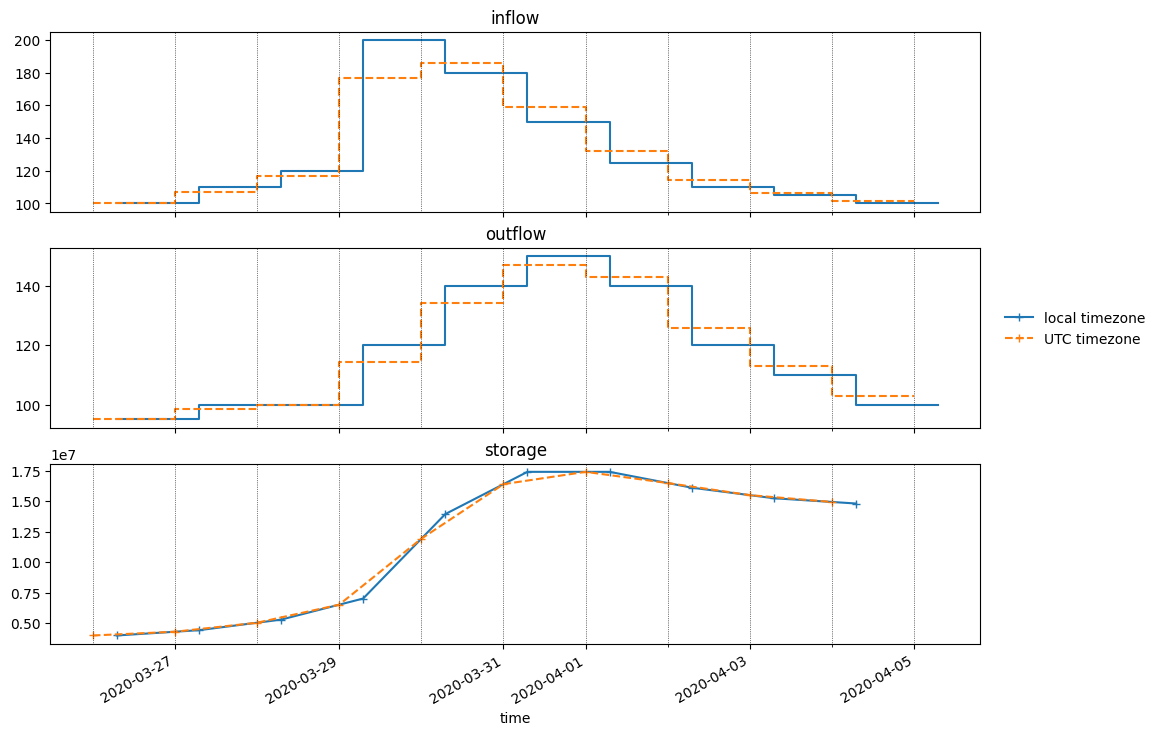

In [4]:
# California
lon = -121
lat = 37

# # Australia
# lon = 150
# lat = -30

# # Madrid
# lon = -3.5
# lat = 40

# # London
# lon = 0
# lat = 51

# convert time series to UTC (with offset)
ts_utc = convert_to_utc(lon, lat, ts)
print(convert_to_utc.local_tz)
print(f'offset: {convert_to_utc.offset} h')

# calculate storage by water balance
ts_utc['storage'] = water_balance_iterative(Vo, ts_utc.inflow, ts_utc.outflow)

# interpolate values to 00 UTC
ts_reindex = reindex_to_00utc(ts_utc)

# compute storage by water balance
ts_reindex['storage_wb1'] = water_balance_iterative(
    ts_reindex.storage.iloc[0], 
    ts_reindex.inflow, 
    ts_reindex.outflow
)
ts_reindex['storage_wb2'] = water_balance_timestep(
    ts_reindex.storage, 
    ts_reindex.inflow, 
    ts_reindex.outflow
)

plot_tz_conversion(ts_utc, ts_reindex)

ts_reindex

### `.resample()`

In [8]:
variable_kind = {
    'inflow': 'average',
    'outflow': 'average',
    'storage': 'instant'
}

# convert time series to UTC (with offset)
ts_utc = convert_to_utc(lon, lat, ts)
print(convert_to_utc.local_tz)
print(f'offset: {convert_to_utc.offset} h')

# calculate storage by water balance
ts_utc['storage'] = water_balance_iterative(Vo, ts_utc.inflow, ts_utc.outflow)

# interpolate values to 00 UTC
ts_resample = pd.concat(
    [resample_to_00utc(ts_utc[[var]], kind=kind) for var, kind in variable_kind.items()], 
    axis=1
)
# ts_resample.dropna(axis=0, how='all', inplace=True)

# compute storage by water balance
ts_resample['storage_wb1'] = water_balance_iterative(
    ts_resample.storage.iloc[0], 
    ts_resample.inflow, 
    ts_resample.outflow
)
ts_resample['storage_wb2'] = water_balance_timestep(
    ts_resample.storage, 
    ts_resample.inflow, 
    ts_resample.outflow
)

plot_tz_conversion(ts_utc, ts_resample)

ts_resample

Australia/Sydney
offset: 13 h
offset: 13 h
offset: 13 h
offset: 13 h


ValueError: The input time series can't contain missing values

***

## Real data

### Configuration

In [9]:
cfg = DatasetConfig('config_ResOpsUS_v21.yml')

print(f'Time series will be saved in {cfg.PATH_TS}')

Time series will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\time_series


### Attributes


In [10]:
# import all tables of attributes
attributes = read_attributes(cfg.PATH_ATTRS)
print(f'{attributes.shape[0]} reservoirs in the attribute tables')

677 reservoirs in the attribute tables


### Time series
#### Oberserved: ResOpsUS

In [11]:
path_plots = cfg.PATH_TS / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
resops_ts = {}
for grand_id in tqdm(attributes.index[:5], desc='Reading observed time series'): # ID refers to GRanD

    # load timeseries
    file = cfg.PATH_OBS_TS / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, index_col='date')
    else:
        print(f"{file} doesn't exist")

    # remove duplicated index
    series = series[~series.index.duplicated(keep='first')]
    # trim to GloFAS long run period
    start, end = cfg.START, cfg.END
    series = series.loc[start:end,:]
    if series.empty:
        print(f'Reservoir {grand_id} has no observations in the time period from {start} to {end}')
        continue
    # ensure there aren't gaps in the index
    dates = pd.date_range(series.first_valid_index(), series.last_valid_index(), freq='D')
    series = series.reindex(dates)
    series.index.name = 'date'

    # remove negative values
    series[series < 0] = np.nan
    # clean storage time series
    series.storage = clean_storage(series.storage, w=7, error_thr=0.1)
    # clean inflow time series
    series.inflow = clean_inflow(
        series.inflow, 
        storage=series.storage if attributes.loc[grand_id, 'STORAGE'] == 1 else None, 
        outlfow=series.outflow if attributes.loc[grand_id, 'OUTFLOW'] == 1 else None, 
        grad_thr=1e4, 
        balance_thr=5, 
        int_method='linear'
    )
    # save in dictionary
    resops_ts[grand_id] = series

    # plot observed time series
    plot_resops(
        series.storage,
        series.elevation,
        series.inflow,
        series.outflow,
        attributes.loc[grand_id, ['CAP_MCM', 'CAP_GLWD']].values,
        title=grand_id,
        save=path_plots / f'{grand_id:04}_lineplot.jpg'
        )

print(f'{len(resops_ts)} reservoirs in ResOpsUS time series')

Reading observed time series:   0%|          | 0/5 [00:00<?, ?it/s]

5 reservoirs in ResOpsUS time series


### Conversion

In [12]:
for grand_id, ts in resops_ts.items():
    break

In [13]:
   lon, lat = attributes.loc[grand_id, ['LON', 'LAT']]

In [14]:
    # convert time series to UTC (with offset)
    ts_utc = convert_to_utc(lon, lat, ts)
    print(convert_to_utc.local_tz)
    print(f'offset: {convert_to_utc.offset} h')
    
    # interpolate values to 00 UTC
    ts_reindex = reindex_to_00utc(ts_utc)
    
    # # compute storage by water balance
    # ts_reindex['storage_wb1'] = water_balance_iterative(
    #     ts_reindex.storage.iloc[0], 
    #     ts_reindex.inflow, 
    #     ts_reindex.outflow
    # )
    # ts_reindex['storage_wb2'] = water_balance_timestep(
    #     ts_reindex.storage, 
    #     ts_reindex.inflow, 
    #     ts_reindex.outflow
    # )
    

America/Los_Angeles
offset: 7 h


,storage,inflow,outflow,elevation,evaporation
date,,,,,
1970-10-01 00:00:00+00:00,1149.749000,29.733000,NaN,485.269000,NaN
1970-10-02 00:00:00+00:00,1147.684917,27.727000,NaN,485.223667,NaN
1970-10-03 00:00:00+00:00,1148.013667,22.388208,NaN,485.231208,NaN
1970-10-04 00:00:00+00:00,1149.580625,24.541292,NaN,485.265375,NaN
1970-10-05 00:00:00+00:00,1146.882417,34.216292,NaN,485.206292,NaN
...,...,...,...,...,...
2020-08-27 00:00:00+00:00,1280.206750,31.806417,40.351083,488.071375,NaN
2020-08-28 00:00:00+00:00,1278.244708,29.590042,52.117083,488.030167,NaN
2020-08-29 00:00:00+00:00,1277.215167,28.576250,41.644292,488.008625,NaN


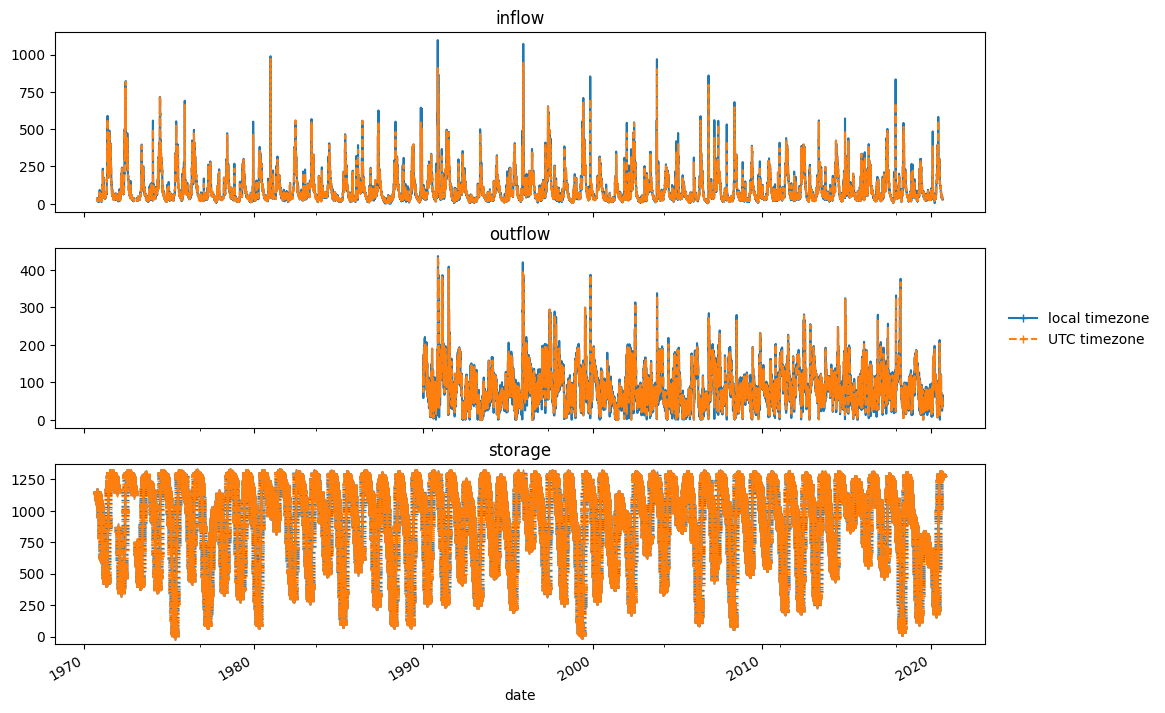

In [15]:
    plot_tz_conversion(ts_utc, ts_reindex, plot_dates=False)
    
    ts_reindex

In [20]:
ts.evaporation.notnull().sum()

np.int64(0)

In [24]:
ts.elevation.notnull().sum(), ts.shape[0]

(np.int64(18130), 18233)

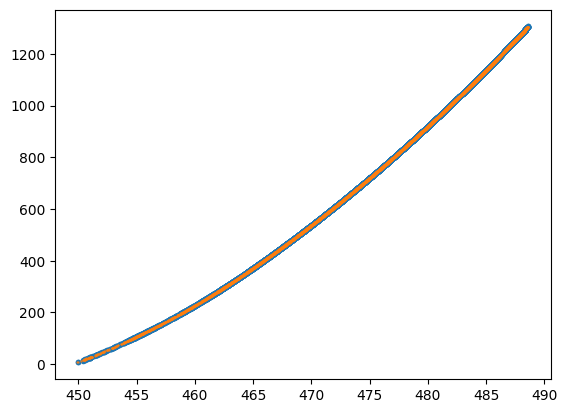

In [30]:
plt.scatter(ts.elevation, ts.storage, marker='.')
plt.scatter(ts_reindex.elevation, ts_reindex.storage, marker='.', s=1)

In [32]:
ts.inflow.mean(), ts_reindex.inflow.mean()

(np.float64(92.75312505379499), np.float64(92.76371699903154))

In [33]:
ts.outflow.mean(), ts_reindex.outflow.mean()

(np.float64(91.10419194714757), np.float64(91.10384110937946))

In [34]:
ts.storage.mean(), ts_reindex.storage.mean()

(np.float64(909.9093264268744), np.float64(909.9042265248786))

In [16]:
ts.sum()

storage        1.646845e+07
inflow         1.685881e+06
outflow        1.020458e+06
elevation      8.685107e+06
evaporation    0.000000e+00
dtype: float64

In [17]:
ts_reindex.sum()

storage        1.647746e+07
inflow         1.686259e+06
outflow        1.020454e+06
elevation      8.688530e+06
evaporation    0.000000e+00
dtype: float64

***